In [16]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from sklearn.metrics import accuracy_score

# Реализация KNNClassifier

In [77]:
class KNNClassifier:
    def __init__(
        self,
        number_of_neighbors: int
    ):
        # задаём количество соседей
        self.k = number_of_neighbors

    def __distance_between_two_objects__(
        self,
        x1: np.ndarray,
        x2: np.ndarray
    ) -> float:
        
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def __get_distance__(
        self,
        X: np.ndarray,
        start_base: int
    ) -> np.ndarray:
        # вычисляем количество объектов
        n = X.shape[0]
        # инициализируем матрицу расстояний
        # start_base - это для того, чтобы считать расстояния только для новых объектов
        # для которых нужно вычислить предсказания
        # n - start_base - это потому что расстояние мы вычисляем только
        # от новых объектов до старых (между новыми не вычисляем, так как у них нет классов)
        dist_matrix = np.zeros((start_base, n - start_base))

        # считаем расстояния
        for i in range(start_base):
            for j in range(start_base, n):
                dist_matrix[i, j-start_base] = self.__distance_between_two_objects__(x1=X[i], x2=X[j])

        # возвращаем результат
        return dist_matrix
    
    def __get_k_nearest_neighbors_indices__(
        self,
        dist_matrix: np.ndarray,
        k: int,
        start_base: int
    ) -> np.ndarray:
        # сортируем индексы соседей по убыванию расстояний
        nearest_neighbors_indices = np.argsort(dist_matrix, axis=1)

        # получаем индексы ближайших соседей
        k_nearest_neighbors_indices = nearest_neighbors_indices[:, :k]

        # возвращаем результат
        return k_nearest_neighbors_indices
    
    def __get_k_nearest_neighbors_classes__(
        self,
        k_nearest_neighbors_indices: np.ndarray,
        y: np.ndarray,
        start_base: int
    ):
        # получаем классы для каждого из соседей
        k_nearest_neighbors_classes =\
            y[k_nearest_neighbors_indices]

        # выбираем для каждого наиболее часто встречающийся класс
        most_common, _ = mode(k_nearest_neighbors_classes, axis=1)

        # возвращаем предсказанные классы
        return most_common.flatten()
    
    def fit(self,
        X: np.ndarray,
        y: np.ndarray
    ) -> None:
        # запоминаем выборку
        self.X = X.copy(deep=True).to_numpy()
        self.y = y.copy(deep=True).to_numpy()

    def predict(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        # копируем выборку
        X = X.copy()

        # вычисляем количество объектов, для которых будем
        # считать предсказания
        start_base = X.shape[0]

        # конкатенируем с обучающей выборкой (на основе которой предсказываем)
        X = np.vstack([X, self.X])

        # считаем матрицу расстояний
        dist_matrix = self.__get_distance__(X=X, start_base=start_base)

        # считаем индексы ближайших соседей
        k_nearest_neighbors_indices =\
            self.__get_k_nearest_neighbors_indices__(
                dist_matrix=dist_matrix,
                k=self.k,
                start_base=start_base
            )
        
        # вычисляем предсказания
        predictions =\
            self.__get_k_nearest_neighbors_classes__(
                k_nearest_neighbors_indices=k_nearest_neighbors_indices,
                y=self.y,
                start_base=start_base
            )
        
        # возвращаем предсказания
        return predictions

In [78]:
knn = KNNClassifier(number_of_neighbors=2)

knn.fit(X_simple, y_simple)

accuracy_score(y_simple.iloc[:20], knn.predict(X_simple.iloc[:20,:]))

1.0

# Реализация LogisticRegression

loggistic regression = $\sum^{n}_{i = 1} log(1 + e^{-y_{i}<w, x_{i}>})$

In [118]:
class LogisticRegressionBinaryClassifier:
    def __init__(self):
        self.w = None

    def __calc_gradient__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        M: np.ndarray,
        reg: str,
        reg_rate: float,
        batch_size: int
    ) -> np.ndarray:
        grad = (-X.T @ (y / (1 + np.exp(y * M)))) / batch_size

        if reg:
            w_grad = self.w.copy()
            w_grad[-1] = 0

            if reg == 'l1':
                grad += reg_rate * np.sign(w_grad)
            elif reg == 'l2':
                grad += reg_rate * 2 * w_grad

        return grad

    def __calc_M__(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        M = X @ self.w

        return M

    def fit(
        self,
        X: pd.DataFrame,
        y: pd.DataFrame,
        max_iter: int = 10,
        batch_size: int = 10,
        learning_rate: float = 0.01,
        reg: str = None,
        reg_rate: float = 0.0
    ) -> None:
        X = X.copy(deep=True).to_numpy()
        y = y.copy(deep=True).to_numpy()

        y = y.reshape(-1, 1)
        n_samples, n_classes = X.shape
        
        X_train = np.hstack((X, np.ones((n_samples, 1))))

        self.w = np.random.randn(n_classes + 1, 1)

        self.losses = []

        for _ in range(max_iter):
            random_indices = np.random.choice(len(X_train), size=batch_size, replace=False)

            M = self.__calc_M__(X=X_train[random_indices])

            self.losses.append(accuracy_score(y[random_indices], np.sign(M)))

            grad = self.__calc_gradient__(
                X=X_train[random_indices],
                y=y[random_indices],
                M=M,
                reg=reg,
                reg_rate=reg_rate,
                batch_size=batch_size
            )

            self.w -= learning_rate * grad

    def predict(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        n_samples = X.shape[0]

        X = np.hstack((X, np.ones((n_samples, 1))))

        M = self.__calc_M__(X)

        predictions = np.sign(M)

        return predictions
    
    def get_weights(self):
        return self.w.copy()
    
    def get_losses(self):
        return self.losses.copy()

In [119]:
class LogisticRegressionManyClassifier:
    def __init__(self):
        self.w = None

    def __to_one_hot__(
        self,
        y: np.ndarray,
        n_classes: int
    ) -> np.ndarray:
        n_samples = y.shape[0]

        Y_one_hot = np.zeros((n_samples, n_classes))
        Y_one_hot[np.arange(n_samples), y] = 1

        return Y_one_hot

    def __calc_gradient__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        P: np.ndarray,
        reg: str,
        reg_rate: float,
        n_classes: int,
        batch_size: isinstance
    ) -> np.ndarray:
        Y_one_hot = self.__to_one_hot__(
            y=y,
            n_classes=n_classes
        )

        grad = (X.T @ (P - Y_one_hot)) / batch_size

        if reg:
            w_grad = self.w.copy()
            w_grad[-1, :] = 0

            if reg == 'l1':
                grad += reg_rate * np.sign(w_grad)
            elif reg == 'l2':
                grad += reg_rate * 2 * w_grad

        return grad

    def __calc_M__(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        M = X @ self.w

        return M

    def fit(
        self,
        X: pd.DataFrame,
        y: pd.DataFrame,
        max_iter: int = 10,
        batch_size: int = 10,
        learning_rate: float = 0.01,
        reg: str = None,
        reg_rate: float = 0.0
    ) -> None:
        X = X.copy(deep=True).to_numpy()
        y = y.copy(deep=True).to_numpy()

        n_classes = np.unique(y).shape[0]
        y = y.reshape(-1, 1)
        n_samples, n_features = X.shape
        
        
        X_train = np.hstack((X, np.ones((n_samples, 1))))

        self.w = np.random.randn(n_features + 1, n_classes)

        self.losses = []

        for _ in range(max_iter):
            random_indices = np.random.choice(len(X_train), size=batch_size, replace=False)

            M = self.__calc_M__(X=X_train[random_indices])
            P = np.exp(M) / np.sum(np.exp(M), axis=1, keepdims=True)
            
            predictions = np.argmax(P, axis=1)

            self.losses.append(accuracy_score(y[random_indices], predictions))

            grad = self.__calc_gradient__(
                X=X_train[random_indices],
                y=y[random_indices],
                P=P,
                reg=reg,
                reg_rate=reg_rate,
                n_classes=n_classes,
                batch_size=batch_size
            )

            self.w -= learning_rate * grad

    def predict_proba(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        n_samples = X.shape[0]

        X = np.hstack((X, np.ones((n_samples, 1))))

        M = self.__calc_M__(X=X)
        M = M - np.max(M, axis=1, keepdims=True)
        P = np.exp(M) / np.sum(np.exp(M), axis=1, keepdims=True)

        return P

    def predict(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        n_samples = X.shape[0]

        X = np.hstack((X, np.ones((n_samples, 1))))

        M = self.__calc_M__(X=X)
        M = M - np.max(M, axis=1, keepdims=True)
        P = np.exp(M) / np.sum(np.exp(M), axis=1, keepdims=True)

        predictions = np.argmax(P, axis=1)

        return predictions
    
    def get_weights(self):
        return self.w.copy()
    
    def get_losses(self):
        return self.losses.copy()

In [120]:
# Минимальный пример для быстрой проверки
def quick_test():
    # Простейшие данные
    X_simple = pd.DataFrame({
        'feature_1': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
        'feature_2': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
    })
    
    y_simple = pd.DataFrame({
        'target': [1, 1, 1, 1, 1, -1, -1, -1, -1, -1]
    })
    
    print("Минимальный тест:")
    print("X shape:", X_simple.shape)
    print("y shape:", y_simple.shape)
    print("\nДанные X:")
    print(X_simple.head())
    print("\nМетки y:")
    print(y_simple.head())
    
    # Тестируем модель
    model = LogisticRegressionBinaryClassifier()
    model.fit(X_simple, y_simple, max_iter=20, batch_size=5)
    
    predictions = model.predict(X_simple.to_numpy())
    accuracy = accuracy_score(y_simple.to_numpy().flatten(), predictions.flatten())
    
    print(f"\nAccuracy на обучающих данных: {accuracy:.2f}")
    print(f"Веса модели: {model.get_weights()}")
    print(f"Ошибки модели: {model.get_losses()}")

# Запуск минимального теста
quick_test()

Минимальный тест:
X shape: (10, 2)
y shape: (10, 1)

Данные X:
   feature_1  feature_2
0          1          1
1          2          1
2          3          1
3          4          1
4          5          1

Метки y:
   target
0       1
1       1
2       1
3       1
4       1

Accuracy на обучающих данных: 0.60
Веса модели: [[ 0.4502805 ]
 [-0.70437611]
 [-1.13274735]]
Ошибки модели: [0.4, 0.6, 0.8, 0.6, 0.4, 0.8, 0.6, 0.6, 0.6, 1.0, 0.8, 0.8, 0.8, 1.0, 0.8, 0.6, 0.6, 1.0, 0.8, 0.4]


In [109]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs
import matplotlib.pyplot as plt

def create_simple_2d_dataset(n_samples=100, random_state=42):
    """Создает простой двумерный набор данных с 3 классами"""
    X, y = make_blobs(n_samples=n_samples, 
                      centers=3, 
                      n_features=2, 
                      cluster_std=1.5, 
                      random_state=random_state)
    
    # Преобразуем в pandas
    X_df = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
    y_series = pd.Series(y, name='target')
    
    return X_df, y_series

# Создаем данные
X_simple, y_simple = create_simple_2d_dataset()

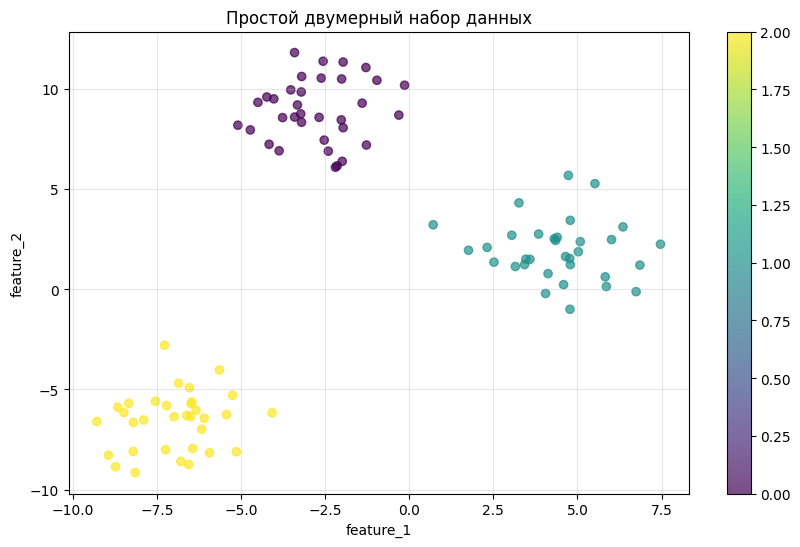

In [110]:
def visualize_2d_dataset(X, y, title="Визуализация данных"):
    """Визуализирует двумерный набор данных"""
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

# Визуализируем простой набор данных
visualize_2d_dataset(X_simple, y_simple, "Простой двумерный набор данных")

In [112]:
model = LogisticRegressionManyClassifier()
model.fit(X_simple, y_simple, max_iter=100, batch_size=10, reg='l2', learning_rate=0.1)

accuracy_score(y_simple.iloc[:20], model.predict(X_simple.iloc[:20,:]))

0.7